# pysamoo: Surrogate-Assisted Multi-objective Optimization

In practice, most optimization problems in practice consist of one or multiple **computationally expensive** objective or constraint functions to which special attention must be paid during algorithm design. Most commonly, so-called surrogates (also known as metamodels or simply approximation models) are utilized during optimization to learn from previous evaluations and exploit this knowledge in future iterations. **pysamoo**  is an extension of [pymoo](https://pymoo.org) - a comprehensive toolbox for multi-objective optimization - focusing on solving optimization problems with computationally expensive objective or constraint functions.

Please find the Github repository here: https://github.com/anyoptimization/pysamoo

![title](_img/surrogate.png)

Please find an overview of this software documentation below:

# License

**GNU Affero General Public License (AGPL)**: The GNU Affero General Public License is a modified version of the ordinary GNU GPL version 3. It has one added requirement: if you run a modified program on a server and let other users communicate with it there, your server must also allow them to download the source code corresponding to the modified version running there.

# Citation

# Installation

The framework is available at the PyPi Repository and can be easily installed by:

# Algorithms

In this part of the software documentation, some more words about the algorithms being implemented in the framework shall be said. 

Commonly, surrogates -- approximation or interpolation models -- are utilized during optimization to improve the convergence behavior. 
First, one shall distinguish between two different types of evaluations: ESEs that require to run the computationally expensive evaluation; and ASEs which is a computationally inexpensive approximation by the surrogate. 
Where the overall optimization run is limited by $\texttt{ESE}^{\max}$ function evaluation, function calls of ASEs are only considered as algorithmic overhead. 

## Simple Surrogate Assisted (SSA)

In order to improve the convergence of NSGA-II, the surrogates provide ASEs and let the algorithm look several iterations into the future without any evaluation of ESEs. 
The surrogate models are used to create a set of infill solutions as follows: First, NSGA-II is run for $k$ more iterations (starting from the best solutions found so far), returning the solution set $X^{\texttt{(cand)}}$.
The number of solutions in $X^{\texttt{(cand)}}$ corresponds to the population size of the algorithm.
After eliminating duplicates in $X^{\texttt{(cand)}}$, the number of solutions $N$ desired to run using ESEs needs to be selected. The selection first creates $N$ clusters (in the objective space based on $X^{\texttt{(cand)}}$) using the k-means algorithm and then uses a roulette wheel selection based on the predicted crowding distances. Note that this will introduce a bias towards boundary points as they have been depicted with a crowding distance of infinity.
Altogether, this results in $N$ solutions to be then evaluated using ESEs in this optimization cycle.


<div style="text-align: center;">
    <img src="_img/ssa.svg" alt="SSA-NSGA-II" width="350">
</div>

## PSAF

In contrast to most existing surrogate-assisted algorithms, PSAF uses not only the final solution(s) obtained by optimizing the surrogate but the whole *search pattern*. By making use of the search pattern, the exploration-exploitation balance is found by taking the surrogate's accuracy into account. To allow even more flexible exploitation of the surrogate, we propose two phases. First, derive a solution set that is influenced by the surrogate, and second, introduce surrogate bias by optimizing the surrogate for a number of iterations. Both procedures are important to incorporate surrogates into existing methods effectively.

One of the major challenges when proposing a generalized optimization framework is the number and strictness of assumptions being made. 
On the one hand, too many assumptions restrict the applicability; on the other hand, too few assumptions limit the usage of existing elements in algorithms.
In this study, we target any type of population-based algorithm with two phases in an iteration: the process of generating new solutions to be evaluated (infill) and a method processing evaluated infill solutions (advance). 
So, how can existing optimization methods be described into *infill* and *advance* phases?
Genetic algorithms (GAs) generate new solutions using evolutionary recombination-mutation operators and then process them using an environmental survival selection operator; PSO methods create new solutions based on a particles' current velocity, personal best, and global best, and process the solutions using a replacement strategy; CMAES samples new solutions from a normal distribution, which is then updated in each iteration. Shown by well-known state-of-the-art algorithms following or being suitable to be implemented in this optimization method design pattern, this seems to be a reasonable assumption to be made for a generic framework. Moreover, it is worth noting that some researchers and practitioners also refer to the pattern as *ask-and-tell* interface.

<div style="text-align: center;">
    <img src="_img/infill_and_advance.png" alt="SSA-NSGA-II">
</div>

### $\alpha$-Phase

A well-known concept in evolutionary computation to introduce a bias toward more promising solutions is *tournament selection*. An individual from the population has to win a tournament to contribute to the mating process.
The number of competitors ($\alpha$) balances how greedy the selection procedure will be. On the one hand, a larger value of $\alpha$ allows only elitist solutions to participate in mating, while a smaller value introduces less selection pressure.
For genetic algorithms, the most frequently used tournament mode is the binary tournament ($\alpha=2$), which compares a pair of solutions regarding one or multiple metrics. A standard binary tournament implementation for constrained single-objective optimization declares the less infeasible solution as the winner if one or both solutions are infeasible or otherwise the solution with the smaller function value.

In the context of surrogate assistance, the tournament selection introduces surrogate bias during the generation of new infill solutions.
Whereas in genetic algorithms, evaluated solutions (using ESE) compete with each other during mating selection, in PSAF solutions evaluated on the surrogate (ASE) are compared.

<div style="text-align: center;">
    <img src="_img/alpha.svg" alt="SSA-NSGA-II" width="700">
</div>

### $\beta$-Phase

While the tournament is an effective concept to incorporate the surrogate's approximation, it is limited by looking only a *single* iteration into the future. To further increase the surrogate's impact, the baseline algorithm is continued to run for $\beta$ more consecutive iterations on the surrogate's approximations.
Inevitably, the question of how many iterations are suitable arises and indicates the importance of tuning $\beta$.
Nevertheless, even more critical, how should the algorithm profit from simulating the algorithm on the surrogate?
An inappropriate choice of  $\beta$ will cause the surrogate's optimum to be repeatedly found and will entirely discard the baseline algorithm's default infill procedure. 
This also causes a diversity loss of infill solutions and does not account for the surrogate's approximation error. Thus, we propose a probabilistic surrogate-assisted approach that balances the surrogate's impact on the baseline algorithm to address these issues.


An example with five iterations ($\beta = 5$) and four infill solutions $X_1$, $X_2$, $X_3$, and $X_4$ is also illustrated in the figure below. Calling the infill function of the baseline algorithm results in five solution sets with four solutions each. When running the algorithm, the assignment takes place, and for instance, $X_1$ has four solutions being the closest to, and $X_4$ has six. The assignment of the closest solution will show cluster-like arrangements and preserve diversity.

<div style="text-align: center;">
    <img src="_img/beta.png" alt="SSA-NSGA-II" width="350">
</div>

For more information please we would like to the corresponding publication:

## GPSAF

Next, PSAF shall be extended to be suitable to handle multiple objectives and constraints.
GPSAF follows the two-phase concept as PSAF. However, the $\alpha$-phase and the $\beta$-phase now have to consider multiple criteria when comparing solutions.



- Extension of PSAF to constrained and multi-objective optimization
- What needs to be modified?
    - Multiple Surrogates: One for each constraint, one for each objective
    - Solution Comparisons: Instead of comparing only the objective, the constraint satisfaction and Pareto Dominance now need to be considered.
    - Exploration vs. Exploitation: The bottle variable rho needs to be redefined.

For single-objective optimization, the $\alpha$-phase has already been described. There, the comparison of the two solutions is based only on one single objective value. 
For the more generic version with constrainAnalogously to PSAF, GPSAF further increases the surrogate's impact by looking $\beta$ iterations into the future through calling infill *and* advance of the baseline algorithm repetitively.
To obtain the $\beta$-solution for constrained multi-objective problems, we use a so-called Probabilistic Knockout Tournament (PKT) to select solutions from each cluster with the goal of self-adaptively exploiting surrogates. The goal is to use surrogates more when they provide accurate predictions but use them more carefully when they provide only rough estimations. 
Necessary for generalization, PKT also applies to problems with multiple objectives and constraints, often with varying complexities and surrogate errors to be considered.ts and objectives, the winner of each solution pool is determined as follows: if *all* solutions are infeasible, select the least infeasible solution; otherwise, select a non-dominated solution (break ties randomly). For both the constraint and objective values, only ASEs are used. 
Otherwise, the $\alpha$-phase remains the same, including its responsibilities and mechanics.

Analogously to PSAF, GPSAF further increases the surrogate's impact by looking $\beta$ iterations into the future through calling infill *and* advance of the baseline algorithm repetitively.
To obtain the $\beta$-solution for constrained multi-objective problems, we use a so-called PKT to select solutions from each cluster with the goal of self-adaptively exploiting surrogates. The goal is to use surrogates more when they provide accurate predictions but use them more carefully when they provide only rough estimations. 
Necessary for generalization, PKT also applies to problems with multiple objectives and constraints, often with varying complexities and surrogate errors to be considered.

<div style="text-align: center;">
    <img src="_img/gpsaf_beta.svg" alt="SSA-NSGA-II" width="700">
</div>

For more information please we would like to the corresponding publication:

# Usage

In general, *pysamoo* uses the main functionalities of pymoo for defining the optimization problem. However, it provides a new set of algorithms designed for computationally expensive functions. 

## SSA-NSGA-II

For bi-objective optimization problems, a variant of NSGA-II called Simple Surrogate Assisted NSGA-II (SSA-NSGA-II) could be a good starting point. 

n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv     
     1 |       50 |      8 |  1.5264428232 |  2.2537834613 |  0.000000E+00
     2 |       60 |     12 |  0.0447088272 |  0.5062280434 |  0.6033429744
     3 |       70 |     20 |  0.0317166787 |  0.1679151161 |  0.6185749342
     4 |       80 |     24 |  0.0254483220 |  0.0084090160 |  0.6309981786
     5 |       90 |     29 |  0.0230370295 |  0.0144214557 |  0.6344052194
     6 |      100 |     35 |  0.0212245222 |  0.0132708565 |  0.6370941415
     7 |      110 |     42 |  0.0195966238 |  0.0130647742 |  0.6396760863
     8 |      120 |     48 |  0.0177374193 |  0.0108200540 |  0.6420831108
     9 |      130 |     50 |  0.0175224609 |  0.0174397893 |  0.6422432439
    10 |      140 |     53 |  0.0158996130 |  0.0094427526 |  0.6444796025
    11 |      150 |     59 |  0.0153706224 |  0.0176365671 |  0.6454315717
    12 |      160 |     63 |  0.0138676188 |  0.0168468611 |  0.6472923167
    13 |      170 |     6

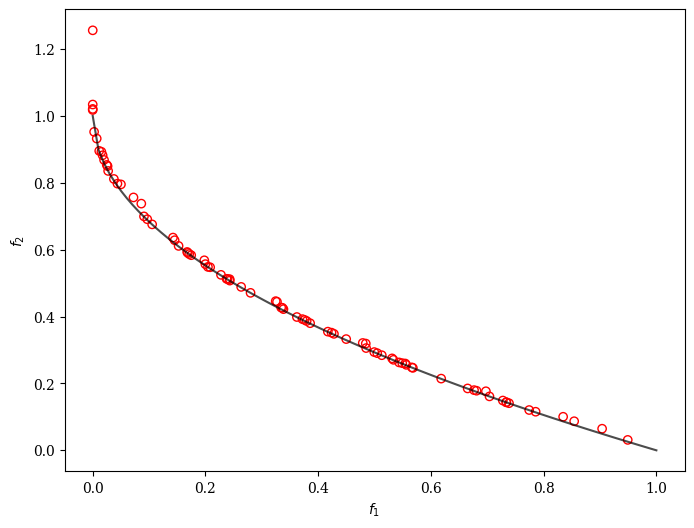

In [1]:
from pymoo.optimize import minimize
from pymoo.problems.multi.zdt import ZDT1
from pymoo.visualization.scatter import Scatter
from pysamoo.algorithms.ssansga2 import SSANSGA2

problem = ZDT1(n_var=10)

algorithm = SSANSGA2(n_initial_doe=50,
                     n_infills=10,
                     surr_pop_size=100,
                     surr_n_gen=50)

res = minimize(
    problem,
    algorithm,
    ('n_evals', 200),
    seed=1,
    verbose=True)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

## PSAF-GA

In [2]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.problems.single import Ackley
from pysamoo.algorithms.psaf import PSAF

problem = Ackley(n_var=10)

algorithm = GA(pop_size=20, n_offsprings=10)

algorithm = PSAF(algorithm, n_initial_doe=30, alpha=10, beta=30, max_rho=0.7, n_max_infills=10, n_max_doe=500)

res = minimize(
    problem,
    algorithm,
    ('n_evals', 300),
    seed=2,
    verbose=True)

print("Best solution found: \nX = %s\nF = %s\nCV=%s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     f_min     |     f_gap     |       r2      |      bias     |      mae      |                            model                            
     1 |       30 |  2.036794E+01 |  2.036794E+01 |             - |             - |  0.2738756231 |             RBF[kernel=linear,tail=constant,normalized=True]
     2 |       40 |  1.614481E+01 |  1.614481E+01 |  0.3763933967 |  0.7000000000 |  0.5348634440 |     RBF[kernel=cubic,tail=linear+quadratic,normalized=False]
     3 |       50 |  1.614481E+01 |  1.614481E+01 |  0.3976668792 |  0.7000000000 |  0.6351592863 |             RBF[kernel=linear,tail=constant,normalized=True]
     4 |       60 |  1.479848E+01 |  1.479848E+01 |  0.2795887538 |  0.7000000000 |  0.8588945004 |        RBF[kernel=mq,tail=linear+quadratic,normalized=False]
     5 |       70 |  1.310293E+01 |  1.310293E+01 | -2.495997E-01 |  0.7000000000 |  1.0450900866 |    RBF[kernel=linear,tail=linear+quadratic,normalized=False]
     6 |       80 |  1.268252E+01 

## PSAF-DE

In [3]:
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.problems.single import Ackley
from pysamoo.algorithms.psaf import PSAF

problem = Ackley(n_var=10)

algorithm = DE(pop_size=20, n_offsprings=10)

algorithm = PSAF(algorithm, n_initial_doe=30, alpha=10, beta=30, max_rho=0.7, n_max_infills=10, n_max_doe=500)

res = minimize(
    problem,
    algorithm,
    ('n_evals', 300),
    seed=2,
    verbose=True)

print("Best solution found: \nX = %s\nF = %s\nCV=%s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     f_min     |     f_gap     |       r2      |      bias     |      mae      |                            model                            
     1 |       30 |  2.036794E+01 |  2.036794E+01 |             - |             - |  0.2738756231 |             RBF[kernel=linear,tail=constant,normalized=True]
     2 |       40 |  1.647220E+01 |  1.647220E+01 |  0.3763933967 |  0.7000000000 |  0.6182901894 |     RBF[kernel=cubic,tail=linear+quadratic,normalized=False]
     3 |       50 |  1.647220E+01 |  1.647220E+01 |  0.3341034259 |  0.7000000000 |  1.0337146201 |               RBF[kernel=linear,tail=linear,normalized=True]
     4 |       60 |  1.647220E+01 |  1.647220E+01 | -2.325472E-01 |  0.7000000000 |  1.1952242311 |               RBF[kernel=linear,tail=linear,normalized=True]
     5 |       70 |  1.526461E+01 |  1.526461E+01 | -2.483244E-01 |  0.7000000000 |  1.3548503486 |               RBF[kernel=linear,tail=linear,normalized=True]
     6 |       80 |  1.353941E+01 

## PSAF-CMAES

In [4]:
from pymoo.algorithms.soo.nonconvex.cmaes import SimpleCMAES
from pymoo.optimize import minimize
from pymoo.problems.single import Ackley
from pysamoo.algorithms.psaf import PSAF

problem = Ackley(n_var=10)

algorithm = SimpleCMAES(pop_size=20)

algorithm = PSAF(algorithm, n_initial_doe=30, alpha=10, beta=30, max_rho=0.7, n_max_infills=10, n_max_doe=500)

res = minimize(
    problem,
    algorithm,
    ('n_evals', 300),
    seed=2,
    verbose=True)

print("Best solution found: \nX = %s\nF = %s\nCV=%s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     f_min     |     f_gap     |       r2      |      bias     |      mae      |                            model                            
     1 |       30 |  2.036794E+01 |  2.036794E+01 |             - |             - |  0.2738756231 |             RBF[kernel=linear,tail=constant,normalized=True]
     2 |       40 |  1.332973E+01 |  1.332973E+01 |  0.3763933967 |  0.7000000000 |  0.7291380548 |     RBF[kernel=cubic,tail=linear+quadratic,normalized=False]
     3 |       50 |  1.332973E+01 |  1.332973E+01 |  0.2592841419 |  0.7000000000 |  0.9917695888 |        RBF[kernel=mq,tail=linear+quadratic,normalized=False]
     4 |       60 |  1.332973E+01 |  1.332973E+01 |  0.1644667959 |  0.7000000000 |  1.1552330246 |               RBF[kernel=linear,tail=linear,normalized=True]
     5 |       70 |  1.332973E+01 |  1.332973E+01 |  0.3694414291 |  0.7000000000 |  1.5138747301 |               RBF[kernel=linear,tail=linear,normalized=True]
     6 |       80 |  1.332973E+01 

## GPSAF-GA

In [5]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.problems.single import Ackley
from pysamoo.algorithms.gpsaf import GPSAF

problem = Ackley(n_var=10)

algorithm = GA(pop_size=20, n_offsprings=10)

algorithm = GPSAF(algorithm, n_initial_doe=30, alpha=10, beta=30, n_max_infills=10, n_max_doe=500)

res = minimize(
    problem,
    algorithm,
    ('n_evals', 300),
    seed=2,
    verbose=True)

print("Best solution found: \nX = %s\nF = %s\nCV=%s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     f_min     |     f_gap     |  n_influenced |      mae      |                            model                            
     1 |       30 |  2.036794E+01 |  2.036794E+01 |             - |  0.2395537352 |          RBF[kernel=gaussian,tail=quadratic,normalized=True]
     2 |       40 |  9.6180845318 |  9.6180845318 |          4/10 |  0.7292616206 |         RBF[kernel=gaussian,tail=quadratic,normalized=False]
     3 |       50 |  9.5397702619 |  9.5397702619 |          4/10 |  1.2838259268 |         RBF[kernel=gaussian,tail=quadratic,normalized=False]
     4 |       60 |  8.3350419429 |  8.3350419429 |          5/10 |  1.1933475702 |   RBF[kernel=gaussian,tail=linear+quadratic,normalized=True]
     5 |       70 |  8.2371788716 |  8.2371788716 |          4/10 |  1.1919714473 |   RBF[kernel=gaussian,tail=linear+quadratic,normalized=True]
     6 |       80 |  8.0191285291 |  8.0191285291 |          2/10 |  0.8810109187 |                                            kri

## GPSAF-DE

In [6]:
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.problems.single import Ackley
from pysamoo.algorithms.gpsaf import GPSAF

problem = Ackley(n_var=10)

algorithm = DE(pop_size=20, n_offsprings=10)

algorithm = GPSAF(algorithm, n_initial_doe=30, alpha=10, beta=30, n_max_infills=10, n_max_doe=500)

res = minimize(
    problem,
    algorithm,
    ('n_evals', 300),
    seed=1,
    verbose=True)

print("Best solution found: \nX = %s\nF = %s\nCV=%s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     f_min     |     f_gap     |  n_influenced |      mae      |                            model                            
     1 |       30 |  2.033913E+01 |  2.033913E+01 |             - |  0.2584492905 |                   RBF[kernel=mq,tail=linear,normalized=True]
     2 |       40 |  1.489029E+01 |  1.489029E+01 |          5/10 |  0.4320034794 |                   RBF[kernel=mq,tail=linear,normalized=True]
     3 |       50 |  1.489029E+01 |  1.489029E+01 |          6/10 |  0.5599724717 |               RBF[kernel=linear,tail=linear,normalized=True]
     4 |       60 |  1.203982E+01 |  1.203982E+01 |          8/10 |  0.7991257442 |               RBF[kernel=linear,tail=linear,normalized=True]
     5 |       70 |  1.203982E+01 |  1.203982E+01 |          5/10 |  0.8959677659 |             RBF[kernel=linear,tail=constant,normalized=True]
     6 |       80 |  1.203982E+01 |  1.203982E+01 |          5/10 |  1.0550719580 |             RBF[kernel=linear,tail=constant,no

## GPSAF-ISRES

In [7]:
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pysamoo.algorithms.gpsaf import GPSAF

problem = get_problem("g1")

algorithm = ISRES()

algorithm = GPSAF(algorithm,
                  alpha=3,
                  beta=30,
                  n_max_infills=1)

res = minimize(
    problem,
    algorithm,
    ('n_evals', 50),
    seed=1,
    verbose=True)

print("Best solution found: \nX = %s\nF = %s\nCV=%s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_min     |     f_gap     |  n_influenced
     1 |       27 |  1.714499E+02 |  5.617944E+02 |             - |             - |             -
     2 |       28 |  1.7247367719 |  5.617944E+02 |             - |             - |           1/1
     3 |       29 |  0.000000E+00 |  5.617944E+02 | -6.400043E+00 |  8.5999570206 |           1/1
     4 |       30 |  0.000000E+00 |  5.617944E+02 | -1.079833E+01 |  4.2016695983 |           1/1
     5 |       31 |  0.000000E+00 |  5.617944E+02 | -1.155193E+01 |  3.4480660762 |           1/1
     6 |       32 |  0.000000E+00 |  5.617944E+02 | -1.304470E+01 |  1.9552979195 |           1/1
     7 |       33 |  0.000000E+00 |  5.617944E+02 | -1.454634E+01 |  0.4536595946 |           1/1
     8 |       34 |  0.000000E+00 |  5.617944E+02 | -1.480047E+01 |  0.1995280575 |           1/1
     9 |       35 |  0.000000E+00 |  5.617944E+02 | -1.491833E+01 |  0.0816667392 |           1/1
    10 |       36 | 

## GPSAF-NSGA-II

n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv      |  n_influenced |     mae f1    |     mae f2   
     1 |       21 |      3 |  1.8942829534 |  3.0095912826 |  0.000000E+00 |             - |  2.158343E-16 |  0.1648489778
     2 |       31 |      3 |  0.4620001734 |  0.7493117302 |  0.1510010190 |          4/10 |  2.875825E-16 |  0.1602687910
     3 |       41 |      2 |  0.3371490822 |  0.2924047767 |  0.3268413114 |          2/10 |  3.001494E-16 |  0.1174748180
     4 |       51 |      8 |  0.1408073065 |  0.2210541972 |  0.4390090282 |          4/10 |  3.452678E-16 |  0.0959817810
     5 |       61 |     10 |  0.1408073065 |  0.0554779978 |  0.4390090282 |          2/10 |  3.650537E-16 |  0.0920210809
     6 |       71 |     16 |  0.1221342838 |  0.0449904710 |  0.4557288877 |          4/10 |  4.895776E-16 |  0.0935525354
     7 |       81 |     27 |  0.0827579407 |  0.0468689921 |  0.5246360468 |          4/10 |  4.549254E-16 |  0.0804396406
     8 |       9

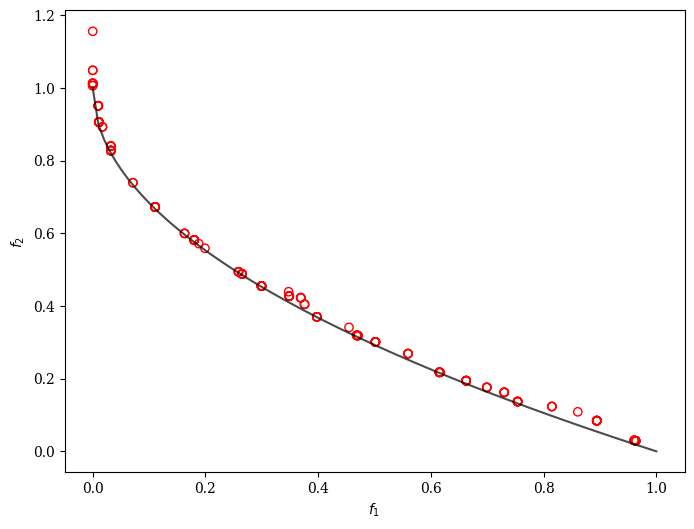

In [8]:
import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.multi import ZDT1
from pymoo.visualization.scatter import Scatter
from pysamoo.algorithms.gpsaf import GPSAF

problem = ZDT1(n_var=10)

algorithm = NSGA2(pop_size=20, n_offsprings=10)

algorithm = GPSAF(algorithm,
                  alpha=10,
                  beta=50,
                  n_max_doe=100,
                  n_max_infills=np.inf,
                  )

res = minimize(
    problem,
    algorithm,
    ('n_evals', 250),
    seed=1,
    verbose=True)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

## GPSAF-NSGA-III

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      igd      |       gd      |       hv      |  n_influenced
     1 |        5 |      1 |  0.5717037305 |  7.3349018351 |             - |             - |             - |             -
     2 |       15 |      2 |  0.000000E+00 |  7.3349018351 |  0.2653544470 |  0.0984902580 |  0.0294105975 |          7/10
     3 |       25 |      6 |  0.000000E+00 |  7.3349018351 |  0.1688552083 |  0.1110745959 |  0.0804323054 |          6/10
     4 |       35 |     12 |  0.000000E+00 |  7.3349018351 |  0.1626975751 |  0.1069272188 |  0.0812678935 |          4/10
     5 |       45 |     16 |  0.000000E+00 |  7.3349018351 |  0.1626975751 |  0.1074034919 |  0.0812678935 |          2/10
     6 |       55 |      7 |  0.000000E+00 |  7.3349018351 |  0.1568291260 |  0.0536053149 |  0.1334154871 |          4/10
     7 |       65 |      9 |  0.000000E+00 |  7.3349018351 |  0.1448912306 |  0.0645102339 |  0.1336500488 |          4/10
     8 |       7

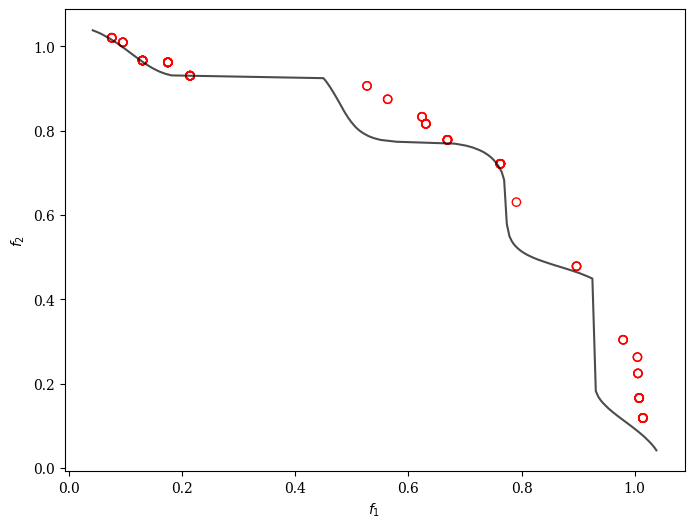

In [9]:
import numpy as np

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.problems.multi import TNK
from pymoo.visualization.scatter import Scatter
from pysamoo.algorithms.gpsaf import GPSAF

problem = TNK()

ref_dirs = get_reference_directions("das-dennis", 2, n_points=20)

# create the algorithm object
algorithm = NSGA3(pop_size=20,
                  n_offsprings=10,
                  ref_dirs=ref_dirs)


algorithm = GPSAF(algorithm,
                  alpha=10,
                  beta=50,
                  n_max_doe=100,
                  )

res = minimize(
    problem,
    algorithm,
    ('n_evals', 200),
    seed=1,
    verbose=True)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

# Tools

## Constrained Sampling for Design of Experiments (DOE)

For more information and more context, please see the following publication:

Let us say our goal is to find 50 feasible designs for the SRN problem. We assume that the constraints are computationally inexpensive in contrast to the objectives requiring a time-consuming evaluation.

In [10]:
from pymoo.problems.multi import SRN
problem = SRN()

n_points = 50

The function returning the constrained violation (CV) given a design can then be implemented by:

In [11]:
def calc_cv(X):
    G = problem.evaluate(X, return_values_of=["G"])
    return np.maximum(G, 0.0).sum(axis=1)

Now let us define a plot function showing the design space and show infeasible solutions in red and feasible ones in blue:

In [12]:
import matplotlib.pyplot as plt

def plot(X):

    xl, xu = problem.bounds()

    def circle(x=0, y=0, r=1):
        theta = np.linspace(0, 2 * np.pi, 100)
        return x + r * np.cos(theta), y + r * np.sin(theta)


    fig, ax = plt.subplots(figsize=(6, 6))
    
    feas = calc_cv(X) <= 0

    ax.scatter(X[feas, 0], X[feas, 1], s=30, facecolors='none', edgecolors='blue')
    ax.scatter(X[~feas, 0], X[~feas, 1], s=30, facecolors='none', edgecolors='red')

    x, y = circle(r=15)
    ax.plot(x, y, color="black", alpha=0.6)

    x = np.linspace(-20, 20)
    y = 1 / 3 * x + 10 / 3
    ax.plot(x, y, color="black", alpha=0.6)

    ax.set_aspect(1)

    ax.set_xlim(xl[0], xu[0])
    ax.set_ylim(xl[1], xu[1])

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    plt.show()


If we perform LHS sampling, the result might look as follows:

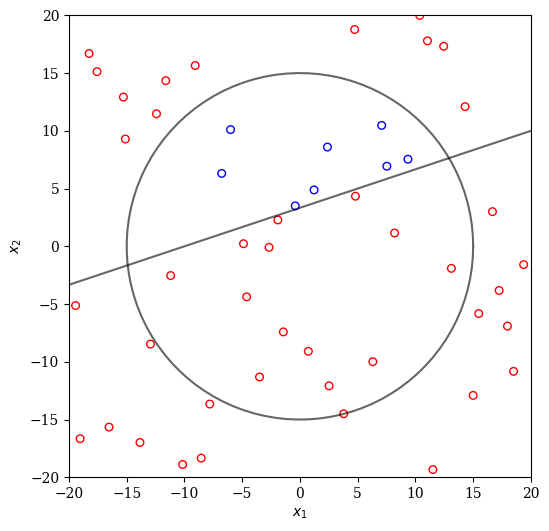

In [13]:
from pymoo.operators.sampling.lhs import LHS

X = LHS().do(problem, n_points).get("X")
plot(X)

Clearly, the majority of designs are infeasible. A simple improvement of this method is repeating the sampling multiple times now until the required number of points has been found.

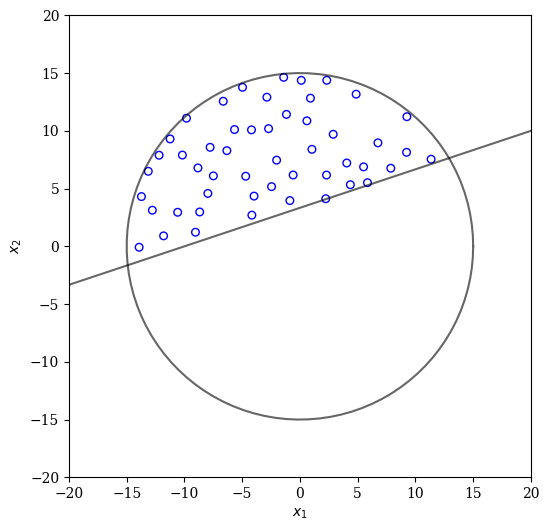

In [14]:
from pysamoo.sampling.rejection import RejectionConstrainedSampling

X = RejectionConstrainedSampling(calc_cv).do(problem, n_points).get("X")
plot(X)

By using a more sophisticated energy-based approach the uniformity can be further improved:

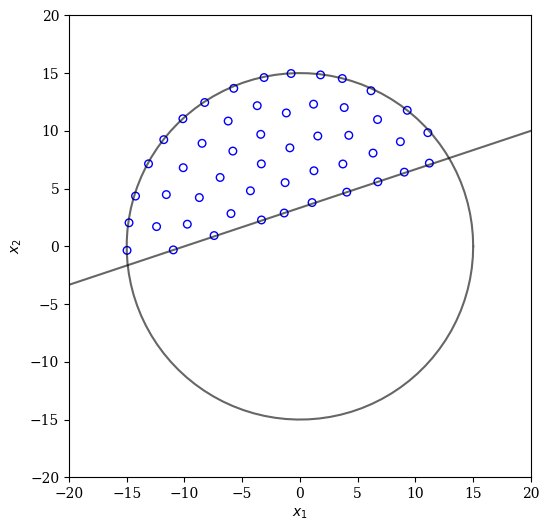

In [15]:
from pysamoo.sampling.energy import EnergyConstrainedSampling

X = EnergyConstrainedSampling(calc_cv).do(problem, n_points).get("X")
plot(X)

# Contact